In [34]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas_datareader as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [35]:
import yfinance as yf

start = "2010-01-01"
end = "2028-01-01"

# Fetch AAPL stock data
krt = yf.Ticker("AAPL")
df = krt.history(start=start, end=end)

# Display the first 20 rows
df.head(20)
data=df.reset_index()
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-01-04 00:00:00-05:00,6.429939,6.462175,6.398307,6.447413,493729600,0.0,0.0
1,2010-01-05 00:00:00-05:00,6.465186,6.495011,6.424515,6.458558,601904800,0.0,0.0
2,2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.0,0.0
3,2010-01-07 00:00:00-05:00,6.379326,6.386858,6.297983,6.344077,477131200,0.0,0.0
4,2010-01-08 00:00:00-05:00,6.335641,6.386856,6.298284,6.386253,447610800,0.0,0.0
...,...,...,...,...,...,...,...,...
3784,2025-01-17 00:00:00-05:00,232.119995,232.289993,228.479996,229.979996,68488300,0.0,0.0
3785,2025-01-21 00:00:00-05:00,224.000000,224.419998,219.380005,222.639999,98070400,0.0,0.0
3786,2025-01-22 00:00:00-05:00,219.789993,224.119995,219.789993,223.830002,64126500,0.0,0.0
3787,2025-01-23 00:00:00-05:00,224.740005,227.029999,222.300003,223.660004,60234800,0.0,0.0


In [36]:
# Ensure the date is in proper datetime format if it's not
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,6.429939,6.462175,6.398307,6.447413,493729600,0.0,0.0
2010-01-05 00:00:00-05:00,6.465186,6.495011,6.424515,6.458558,601904800,0.0,0.0
2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.0,0.0
2010-01-07 00:00:00-05:00,6.379326,6.386858,6.297983,6.344077,477131200,0.0,0.0
2010-01-08 00:00:00-05:00,6.335641,6.386856,6.298284,6.386253,447610800,0.0,0.0
...,...,...,...,...,...,...,...
2025-01-17 00:00:00-05:00,232.119995,232.289993,228.479996,229.979996,68488300,0.0,0.0
2025-01-21 00:00:00-05:00,224.000000,224.419998,219.380005,222.639999,98070400,0.0,0.0
2025-01-22 00:00:00-05:00,219.789993,224.119995,219.789993,223.830002,64126500,0.0,0.0


In [37]:
# Only using 'Close' price for this example
data = data[['Close']]

# Normalize the data using MinMaxScaler (scales data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [38]:
# Function to create the dataset with input (X) and output (y)
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Use past 'time_step' days
        y.append(data[i + time_step, 0])  # Next day's stock price
    return np.array(X), np.array(y)

# Prepare the dataset (60 days for training)
X, y = create_dataset(scaled_data, time_step=60)

In [39]:
# Reshape the input to be 3D for LSTM: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing datasets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [40]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer to predict the next stock price

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0050
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 4.9856e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 4.1092e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.1860e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 3.8210e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 4.0202e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 3.1477e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 3.5630e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 3.2755e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 3.2493e-04


In [43]:
# Make predictions on the test set
predictions = list(model.predict(X_test)) # Get predictions and immediately convert to list
# predictions = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [44]:
# Inverse the scaling to get the predicted stock price in original scale
predictions = scaler.inverse_transform(predictions)

In [45]:
# Get the actual stock price from the test set (inverse scaled)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

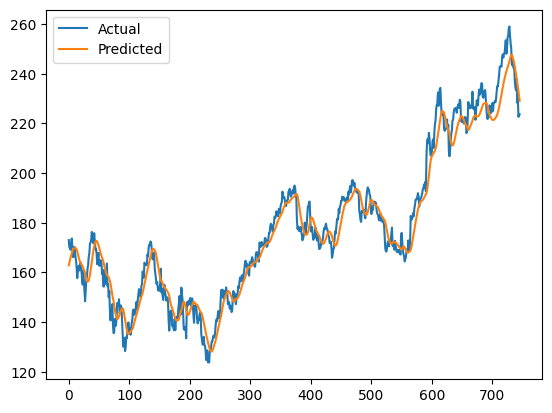

In [46]:
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [47]:
y_test_rescaled[:10]

array([[173.00604248],
       [170.11340332],
       [169.82771301],
       [169.10858154],
       [172.23147583],
       [173.65991211],
       [169.56173706],
       [166.13348389],
       [166.36991882],
       [170.22177124]])

In [48]:
predictions[:10]

array([[162.85079687],
       [163.91648885],
       [164.99712382],
       [166.01359449],
       [166.88350308],
       [167.78800696],
       [168.73826055],
       [169.41947989],
       [169.68934431],
       [169.68816698]])

In [49]:
# Example: Predict the next day's stock price (61st day)
# For this, use the most recent 60 days from the test set
last_60_days = scaled_data[-60:]  # Get the last 60 days from your dataset
last_60_days = last_60_days.reshape(1, 60, 1)  # Reshape for LSTM input

# Predict the next day's price (61st day)
predicted_61st_day = model.predict(last_60_days)

# Inverse transform to get the price in original scale
predicted_61st_day = scaler.inverse_transform(predicted_61st_day)

print(f"Predicted 61st day stock price: {predicted_61st_day[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted 61st day stock price: 225.48287963867188


In [50]:
# Predict future stock prices for a customizable number of days
def predict_future_prices(model, last_60_days, scaler, num_days=10):
    """
    Predict future stock prices for a given number of days.

    Parameters:
    - model: Trained LSTM model.
    - last_60_days: Scaled array of the last 60 days of stock prices.
    - scaler: Scaler used to normalize data.
    - num_days: Number of future days to predict.

    Returns:
    - A list of predicted stock prices (in original scale).
    """
    future_predictions = []
    input_sequence = last_60_days.reshape(1, 60, 1)  # Reshape for LSTM input

    for _ in range(num_days):
        # Predict the next day's price
        next_day_price = model.predict(input_sequence)

        # Append the predicted price (inverse scaled) to the results
        future_predictions.append(scaler.inverse_transform(next_day_price)[0, 0])

        # Update the input sequence: Remove the first day, append the predicted day
        input_sequence = np.append(input_sequence[:, 1:, :], [[next_day_price[0]]], axis=1)

    return future_predictions

# Use the last 60 days from the dataset to predict the next 10 days
last_60_days = scaled_data[-60:]  # Get the last 60 days from your dataset
num_days_to_predict = 100  # Customize the number of days
future_prices = predict_future_prices(model, last_60_days, scaler, num_days=num_days_to_predict)

# Print the predicted future prices
print(f"Predicted stock prices for the next {num_days_to_predict} days: {future_prices}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Mean Squared Error: 0.7578009192360482
Mean Absolute Error: 0.8228632466176923


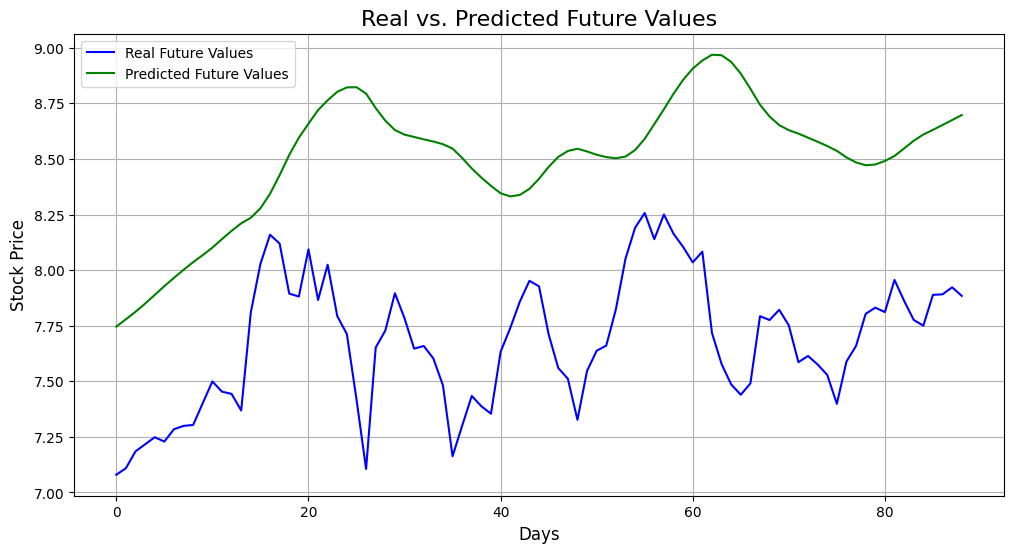

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assume you already have your trained model and data
# We split the data: First 150 days are for input, next 150 for testing

past_values = scaled_data[:150]  # First 150 days
real_future_values = scaled_data[150:300]  # Next 150 days (real future values)

# Prepare input for prediction
X_past, y_future = create_dataset(past_values, time_step=60)
X_past = X_past.reshape(X_past.shape[0], X_past.shape[1], 1)

# Predict the next 150 days using the past 150 days
predicted_future_scaled = model.predict(X_past)

# Inverse scale the predictions and real values to original scale
predicted_future = scaler.inverse_transform(predicted_future_scaled)
real_future_values = scaler.inverse_transform(y_future.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(real_future_values, predicted_future)
mae = mean_absolute_error(real_future_values, predicted_future)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plot real vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(real_future_values, label="Real Future Values", color="blue")
plt.plot(predicted_future, label="Predicted Future Values", color="green")
plt.title("Real vs. Predicted Future Values", fontsize=16)
plt.xlabel("Days", fontsize=12)
plt.ylabel("Stock Price", fontsize=12)
plt.legend(loc="upper left")
plt.grid()
plt.show()


In [53]:
model.save('stock_models.keras')